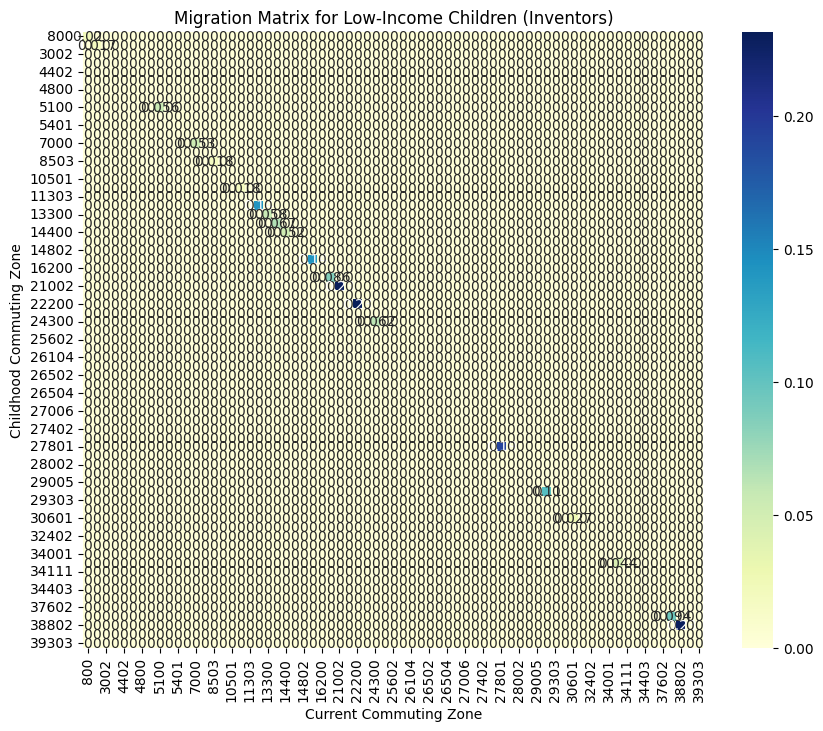

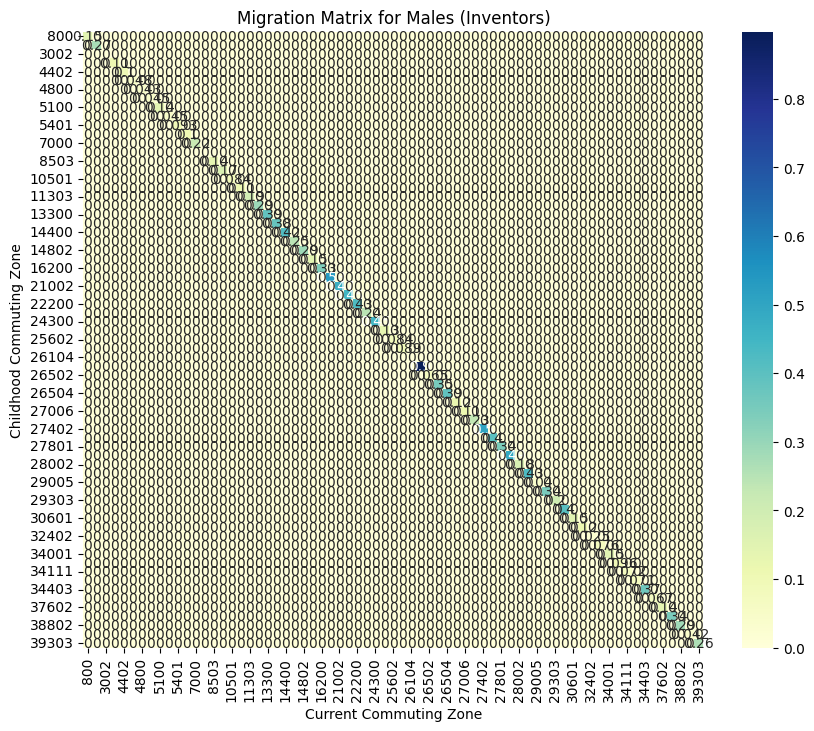

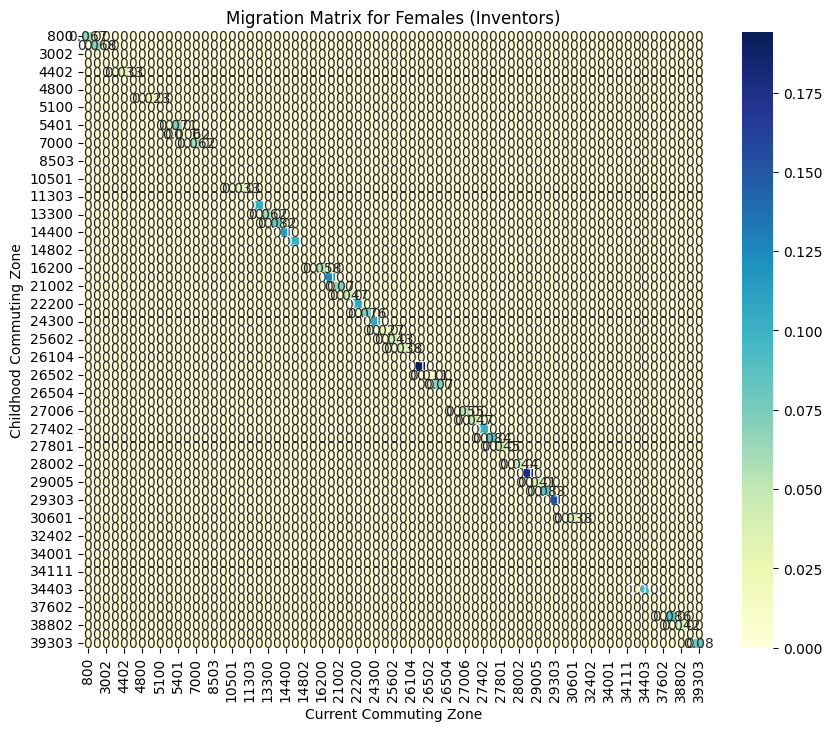

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from tables
table1a = pd.read_csv('./code_and_data/data/excel/table_1a.csv')
table1b = pd.read_csv('./code_and_data/data/excel/table_1b.csv')
table2a = pd.read_csv('./code_and_data/data/excel/table_2a.csv')
table2b = pd.read_csv('./code_and_data/data/excel/table_2b.csv')

table1a = table1a.sample(frac=0.1, random_state=42)  # Sample 10% of rows
table1b = table1b.sample(frac=0.1, random_state=42)  # Sample 10% of rows
table2a = table2a.sample(frac=0.1, random_state=42)  # Sample 10% of rows
table2b = table2b.sample(frac=0.1, random_state=42)  # Sample 10% of rows

# Extract relevant columns
childhood_cz_data = table1a[['par_cz', 'inventor_pq_1', 'inventor_g_m', 'inventor_g_f']]
current_cz_data = table2a[['cz', 'applicant_g_m', 'applicant_g_f']]

# Merge childhood and current commuting zone data
merged_data = pd.merge(childhood_cz_data, current_cz_data, left_on='par_cz', right_on='cz', how='inner')

# Calculate migration matrix for low-income children
migration_matrix_low_income = pd.pivot_table(merged_data, values='inventor_pq_1', index='par_cz', columns='cz', aggfunc='sum', fill_value=0)

# Visualize migration matrix for low-income children
plt.figure(figsize=(10, 8))
sns.heatmap(migration_matrix_low_income, annot=True, cmap='YlGnBu')
plt.title('Migration Matrix for Low-Income Children (Inventors)')
plt.xlabel('Current Commuting Zone')
plt.ylabel('Childhood Commuting Zone')
plt.show()

# Calculate migration matrix for males
migration_matrix_males = pd.pivot_table(merged_data, values='inventor_g_m', index='par_cz', columns='cz', aggfunc='sum', fill_value=0)

# Visualize migration matrix for males
plt.figure(figsize=(10, 8))
sns.heatmap(migration_matrix_males, annot=True, cmap='YlGnBu')
plt.title('Migration Matrix for Males (Inventors)')
plt.xlabel('Current Commuting Zone')
plt.ylabel('Childhood Commuting Zone')
plt.show()

# Calculate migration matrix for females
migration_matrix_females = pd.pivot_table(merged_data, values='inventor_g_f', index='par_cz', columns='cz', aggfunc='sum', fill_value=0)

# Visualize migration matrix for females
plt.figure(figsize=(10, 8))
sns.heatmap(migration_matrix_females, annot=True, cmap='YlGnBu')
plt.title('Migration Matrix for Females (Inventors)')
plt.xlabel('Current Commuting Zone')
plt.ylabel('Childhood Commuting Zone')
plt.show()